In [249]:
from __future__ import division

import numpy as np
from numpy import *

import os

import tensorflow as tf

import PIL
from PIL import Image
import matplotlib.pyplot as plt

from skimage import data, io, filters

from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd

In [250]:
path_to_strokes =  "tiny/airplane.npy"
X = np.load(path_to_strokes)[()]

In [251]:
print('Example sketch has ', str(shape(X['airplane'][0][0])[0]), ' strokes')
print('Corresponds to photo: ', X['airplane'][1][0])

path_to_source_photos = "../tiny/photo/airplane/"
photo = os.path.join(path_to_source_photos,'n02691156_10151.jpg')

('Example sketch has ', '169', ' strokes')
('Corresponds to photo: ', 'n02691156_10151')


In [252]:
class TinyDataset():
    """tiny airplane dataset of photos and sketches for pix2svg."""

    def __init__(self, npy_file, root_dir, transform=None):
        """
        Args:
            npy_file (string): Path to the numpy file with stroke-5 representation and corresponding photos.
                    # to get stroke-5 representation of svg
                    x['airplane'][0][5]
                    # to get corresponding photos
                    x['airplane'][1][5]
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.stroke_dir = npy_file
        self.photo_dir = os.path.join(root_dir,'photo')
        self.strokes = np.load(npy_file)[()]
        self.transform = transform
    
    def __len__(self):
        return len(self.strokes['airplane'][0])

    def __getitem__(self, idx):
        img_name = os.path.join(self.photo_dir,'airplane',X['airplane'][1][idx]+ '.jpg')
        photo = io.imread(img_name)
        photo = photo.astype(float)
        strokes = self.strokes['airplane'][0][idx]
        sample = {'photo': photo, 'strokes': strokes,'name': X['airplane'][1][idx]+ '.jpg'}
        
        if self.transform:
            sample = self.transform(sample)

        return sample    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, strokes, name = sample['photo'], sample['strokes'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))        
        return {'tensor': tf.divide(tf.stack(sample['photo']),255),
                'strokes': strokes,
                'name': name,
                'photo': image}    

def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result    
    
def strokes_to_lines(strokes):
    """
    Convert stroke-3 format to polyline format.
    List contains sublist of continuous line segments (strokes).    
    """
    x = 0
    y = 0
    lines = []
    line = []
    for i in range(len(strokes)):
        if strokes[i, 2] == 1:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
            lines.append(line)
            line = []
        else:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
    return lines

def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2)
    ax.add_patch(patch)
    ax.set_xlim(0,max(max(verts)))
    ax.set_ylim(0,max(max(verts)))
    ax.axis('off')
    plt.gca().invert_yaxis() # y values increase as you go down in image
    plt.show()

In [253]:
%ls

batch_render_tiny_intermediates.ipynb  LICENSE    sketchy/  tf_sketchy.ipynb
helpers.py                             pix2svg/   test      tiny/
helpers.pyc                            README.md  test.png  tiny_intermediates/


In [254]:
## load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',root_dir='/home/jefan/ptsketchy/tiny',transform=None)

(100, (256, 256, 3), (99, 5))


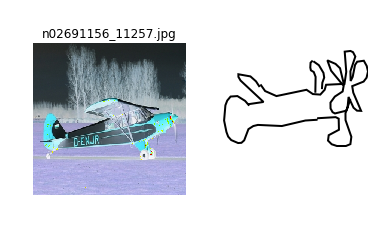

In [256]:
## display given photo and corresponding sketch from stroke-5 representation
i = 100
sample = airplanes[i]
print(i, sample['photo'].shape, sample['strokes'].shape)

plt.figure()
ax = plt.subplot(121)
ax.set_title(sample['name'])
ax.axis('off')
img = np.reshape(sample['photo'],(256,256,3))
plt.imshow(img,interpolation='nearest')

ax = plt.subplot(122)
lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
verts,codes = polyline_pathmaker(lines)
path_renderer(verts,codes)

plt.show()

In [19]:
# load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',
                        root_dir='/home/jefan/ptsketchy/tiny',
                        transform=ToTensor())

In [28]:
# load in features for photos
path_to_features = 'sketchy/triplet_features'
photo_features = np.load(os.path.join(path_to_features,'photo_features.npy'))
F = photo_features

In [48]:
# read in filenames and generate pandas dataframe with object labels
_filenames = pd.read_csv(os.path.join(path_to_features,'photo_filenames.txt'),header=None,names=['filename'])

filenames = []
for i in range(len(_filenames)):
    filenames.append(_filenames[_filenames.index==i].values[0][0])
filenames = ['sketchy' + f[1:] for f in filenames]
path = filenames
obj = [f.split('/')[3] for f in filenames]
img = [f.split('/')[4] for f in filenames]

data = {'path': path,
         'object': obj,
         'filename': img}
X = pd.DataFrame.from_dict(data)

In [103]:
# subset airplane features only
matches = X['object']=='airplane'
inds = np.where(matches==True)
X0 = X[matches]
F0 = F[inds]

In [179]:
# construct (12490,1024) version of photo feature matrix, called PF, that matches indexing of the sketch feature matrix
sketch_features = np.load('sketchy/airplane_features/airplane_sketch_features.npy')
_sketch_filenames = pd.read_csv('sketchy/airplane_features/airplane_sketch_filenames.txt',header=None,names=['filename'])
sketch_filenames = []
for i in range(len(_sketch_filenames)):
    sketch_filenames.append(_sketch_filenames[_sketch_filenames.index==i].values[0][0])
PF = []
inds = [] 
for sf in sketch_filenames:
    q = sf.split('/')[2]+'.jpg'
    PF.append(F0[X0['filename']==q])
    inds.append(np.where(X0['filename']==q)[0][0])
PF = np.squeeze(np.array(PF))
SF = sketch_features
inds = np.array(inds)

## zip together/concatenate the photo and sketch features
_F = np.hstack((PF,SF))

In [224]:
# generate random index to do train/val/test split
_idx = np.arange(len(X0))
np.random.seed(seed=0)
np.random.shuffle(_idx)
train_len = int(len(_idx)*0.85)
val_len = int(len(_idx)*0.05)
test_len = int(len(_idx*0.10))

# indices of 100 photos that will go into train/val/test split
train_inds = _idx[:train_len] 
val_inds = _idx[train_len:train_len+val_len]
test_inds = _idx[train_len+val_len:len(_idx)]

# construct 12490 vectors that correspond to membership in train/val/test splits
train_vec = np.zeros(len(F)).astype(bool)
val_vec = np.zeros(len(F)).astype(bool)
test_vec = np.zeros(len(F)).astype(bool)

for i in train_inds:
    train_vec[idx==i] = True
for i in val_inds:
    val_vec[idx==i] = True    
for i in test_inds:
    test_vec[idx==i] = True 
    
# print str(sum(train_vec)/len(train_vec) * len(F)) + ' sketch intermediates to train on.'
# print str(sum(val_vec)/len(val_vec) * len(F)) + ' sketch intermediates to validate on.'
# print str(sum(test_vec)/len(test_vec) * len(F)) + ' sketch intermediates to test on.'    

# # now actually split data
# F_train = F[train_vec]
# F_val = F[val_vec]
# F_test = F[test_vec]
# print np.shape(F_train)

10156.0 sketch intermediates to train on.
830.0 sketch intermediates to validate on.
1504.0 sketch intermediates to test on.


Object `np.intersect` not found.


6377

In [ ]:
### now get a (12490,5) representation of the 'next stroke'
### no wait, instead, just bump up the dimensionality of these feature matrices to fit that of 
### the (delta_x,delta_y) stroke representation
### Strokes dataframe ("S") is of dimensionality (55855,5).
### So, resize and re-index the feature matrix to match S. 

In [340]:
S = pd.read_csv('tiny/stroke_dataframe.csv')
photo_dir = np.array([sf.split('/')[2] for sf in sketch_filenames]) # photo dir
sketch_dir = np.array(map(int,[sf.split('/')[3] for sf in sketch_filenames])) # sketch dir
stroke_png = np.array(map(int,[sf.split('/')[4].split('.')[0] for sf in sketch_filenames])) # stroke png

F = []
for index, row in S.iterrows():
    # get ind of the original small (12490,5) matrix that corresponds to this row of S (55855,5)
    ind = np.intersect1d(np.intersect1d(np.where(photo_dir==row['photoID']),
              np.where(sketch_dir==row['sketchID'])),
              np.where(stroke_png==row['strokeID']))[0]
    F.append(_F[ind])
    
    

In [309]:
# S['photoID']==sketch_filenames[0].split('/')[2]

'n02691156_9966.jpg'

In [ ]:
# generate 55855-long vector of photo indices
print 'generating list of photo indices based on X0'
inds = [] 
for index, row in S.iterrows():
    q = row['photoID']+'.jpg'
    inds.append(np.where(X0['filename']==q)[0][0])
inds = np.array(inds)

# generate random index to do train/val/test split
print 'generating random index to do train/val/test split'
_idx = np.arange(len(X0))
np.random.seed(seed=0)
np.random.shuffle(_idx)
train_len = int(len(_idx)*0.85)
val_len = int(len(_idx)*0.05)
test_len = int(len(_idx*0.10))

# indices of 100 photos that will go into train/val/test split
train_inds = _idx[:train_len] 
val_inds = _idx[train_len:train_len+val_len]
test_inds = _idx[train_len+val_len:len(_idx)]

print 'constructing 55855 vectors that correspond to membership in train/val/test splits'
# construct 55855 vectors that correspond to membership in train/val/test splits
train_vec = np.zeros(len(F)).astype(bool)
val_vec = np.zeros(len(F)).astype(bool)
test_vec = np.zeros(len(F)).astype(bool)

for i in train_inds:
    train_vec[inds==i] = True
for i in val_inds:
    val_vec[inds==i] = True    
for i in test_inds:
    test_vec[inds==i] = True 
    
assert sum(train_vec)+ sum(val_vec) + sum(test_vec) == len(train_vec)    
    
print str(sum(train_vec)/len(train_vec) * len(F)) + ' sketch intermediates to train on.'
print str(sum(val_vec)/len(val_vec) * len(F)) + ' sketch intermediates to validate on.'
print str(sum(test_vec)/len(test_vec) * len(F)) + ' sketch intermediates to test on.'    

# now actually split data
F_train = F[train_vec]
F_val = F[val_vec]
F_test = F[test_vec]
print np.shape(F_train)

generating list of photo indices based on X0
